# Fifth Task: Explanation

### Import of the needed libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pydotplus
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import dice_ml

from IPython.display import Image
from sklearn import tree  
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.inspection import permutation_importance
from joblib import dump, load
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
from interpret.blackbox import LimeTabular
from interpret import show
from xailib.explainers.lore_explainer import LoreTabularExplainer
from tqdm import tqdm

2025-01-02 19:52:06.351302: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-02 19:52:06.352417: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-02 19:52:06.356382: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-02 19:52:06.368613: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735843926.388276  133103 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735843926.39

### Import of the dataset and preparing for explanation

In [2]:
data_merged = pd.read_csv('./dataset/data_merged.csv')

# Training set
train_data = data_merged[data_merged['date'] < 2022]
# Test set
test_data = data_merged[data_merged['date'] >= 2022]

# Feature and target for training
train_feature = train_data.drop("top_20", axis="columns").select_dtypes(include="number")
train_target = train_data['top_20']

# Feature and target for testing
test_feature = test_data.drop("top_20", axis="columns").select_dtypes(include="number")
test_target = test_data['top_20']

# Feature names
columns = train_data.columns.tolist()
columns.remove('top_20')

# Full dataset
full_dataset = pd.concat([train_feature, test_feature])

## Utility functions

In [3]:
def plot_feature_importance(model, feature_names):
    """
    Calculate and plot feature importance for a model.

    Parameters:
    - model: Trained model.
    - feature_names: List of feature names corresponding to the input data.
    """
    # Extract feature importance
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.gca().invert_yaxis()
    plt.xlabel('Importance')
    plt.title('Feature Importance')
    plt.show()


### Decision Tree

In [4]:
# Import the model
dt = load('./models/decision_tree.joblib')

#### Feature importance

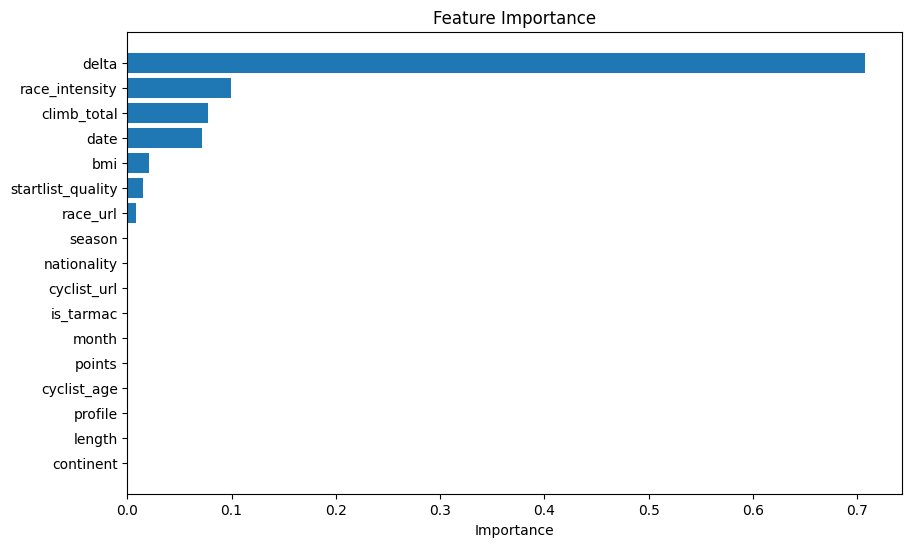

In [5]:
# Plot feature importance
plot_feature_importance(dt, test_feature.columns)

Use of shap

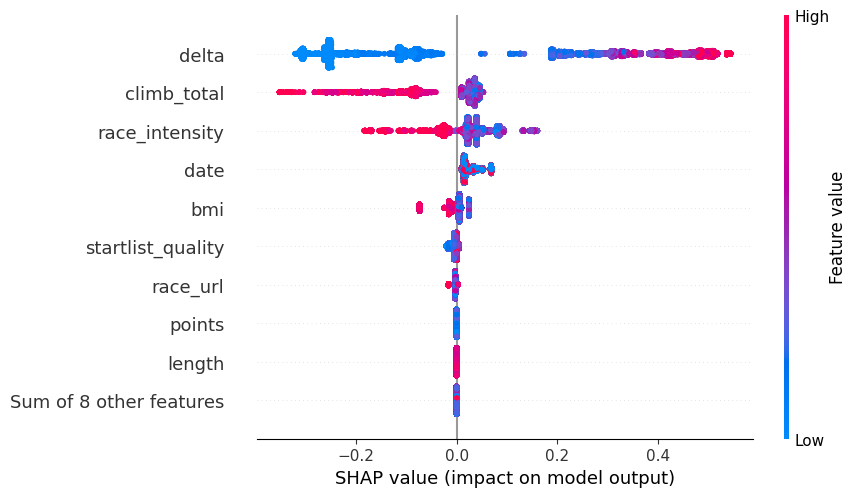

In [6]:
interventional_explanation_algorithm_dt = shap.TreeExplainer(
    model=dt,
    data=train_feature,         # perturb on a causal model induced on perturbation data
    feature_perturbation="interventional"  # use a causal model
)

distributional_explanation_algorithm_dt = shap.TreeExplainer(
    model=dt,
    feature_perturbation="tree_path_dependent"  # condition on the distribution learned on the train data
)

interventional_explanations_dt = interventional_explanation_algorithm_dt(test_feature)
distributional_explanations_dt = distributional_explanation_algorithm_dt(test_feature)

shap.plots.beeswarm(interventional_explanations_dt[:, :, 0])

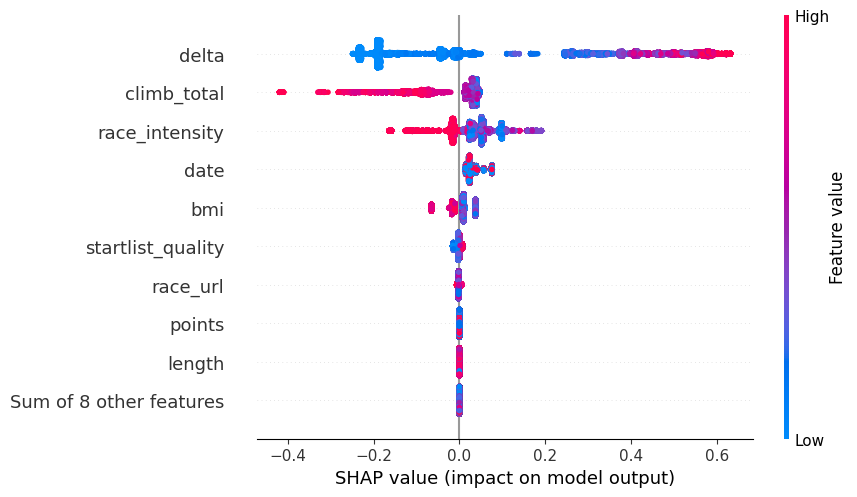

In [7]:
shap.plots.beeswarm(distributional_explanations_dt[:, :, 0])

<Axes: ylabel='Density'>

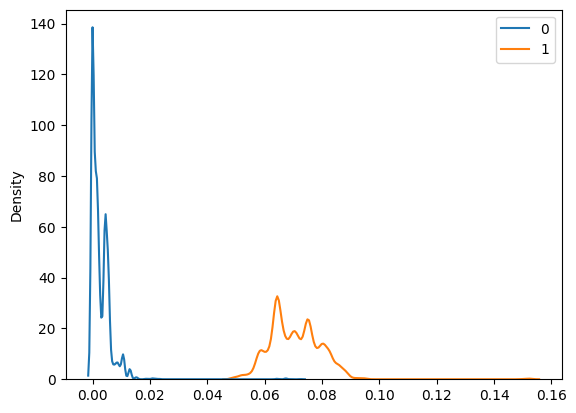

In [8]:
explanation_differences_dt = interventional_explanations_dt.values - distributional_explanations_dt.values

maximum_differences_per_instance_dt = explanation_differences_dt.max(axis=1)
sns.kdeplot(maximum_differences_per_instance_dt)

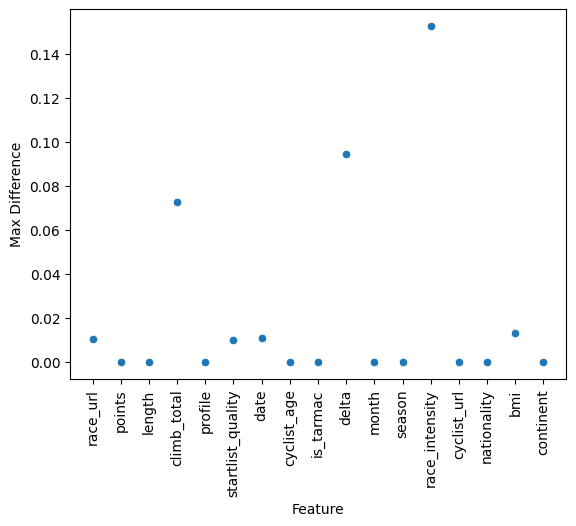

In [9]:
maximum_differences_per_feature_dt = explanation_differences_dt.max(axis=0)

feature_importances_dt = pd.DataFrame({
    'Feature': columns,
    'Max Difference': maximum_differences_per_feature_dt.max(axis=1)
})

sns.scatterplot(x='Feature', y='Max Difference', data=feature_importances_dt)
plt.xticks(rotation=90)
plt.show()

In [10]:
interventional_explanations_df_dt = pd.DataFrame(interventional_explanations_dt[:, :, 0].values, columns=columns)
interventional_explanations_df_dt.describe().drop("count", axis="rows")

,race_url,points,length,climb_total,profile,startlist_quality,date,cyclist_age,is_tarmac,delta,month,season,race_intensity,cyclist_url,nationality,bmi,continent
mean,-0.002614,0.0,0.0,-0.017916,0.0,-0.004230,0.022952,0.0,0.0,0.066549,0.0,0.0,0.020218,0.0,0.0,-0.001388,0.0
std,0.002679,0.0,0.0,0.075926,0.0,0.005627,0.015196,0.0,0.0,0.292288,0.0,0.0,0.050091,0.0,0.0,0.023051,0.0
min,-0.015960,0.0,0.0,-0.351715,0.0,-0.020069,0.009423,0.0,0.0,-0.320447,0.0,0.0,-0.183597,0.0,0.0,-0.073612,0.0
25%,-0.002852,0.0,0.0,-0.080812,0.0,-0.005128,0.014105,0.0,0.0,-0.252390,0.0,0.0,-0.016597,0.0,0.0,-0.009426,0.0
50%,-0.002139,0.0,0.0,0.024406,0.0,-0.005128,0.016669,0.0,0.0,-0.065608,0.0,0.0,0.023537,0.0,0.0,0.003591,0.0
75%,-0.001711,0.0,0.0,0.036339,0.0,0.000000,0.022629,0.0,0.0,0.334518,0.0,0.0,0.040451,0.0,0.0,0.005386,0.0
max,0.001854,0.0,0.0,0.052983,0.0,0.004487,0.070208,0.0,0.0,0.543814,0.0,0.0,0.160182,0.0,0.0,0.024238,0.0


 Plot the kernel density estimate (KDE) of the distribution for the 'race_intensity' feature and select it as interest for later

<Axes: xlabel='race_intensity', ylabel='Density'>

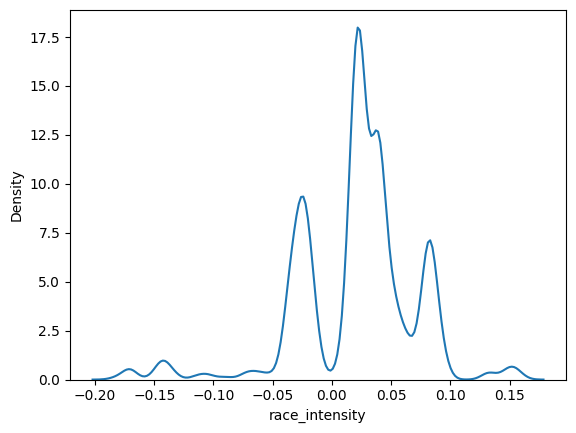

In [11]:
feature_of_interest = "race_intensity"
sns.kdeplot(interventional_explanations_df_dt, x=feature_of_interest)

In [12]:
number_quantiles = 50
quantiles_dt = interventional_explanations_df_dt["delta"].quantile([q / number_quantiles for q in (range(number_quantiles))])

print("Differences between quantiles:\n", quantiles_dt.diff())

Differences between quantiles:
 0.00         NaN
0.02    0.011724
0.04    0.001947
0.06    0.002318
0.08    0.029106
0.10    0.018079
0.12    0.000617
0.14    0.001649
0.16    0.000298
0.18    0.000143
0.20    0.000474
0.22    0.000000
0.24    0.001701
0.26    0.006182
0.28    0.027240
0.30    0.022473
0.32    0.080564
0.34    0.002564
0.36    0.000617
0.38    0.005308
0.40    0.004265
0.42    0.012699
0.44    0.007872
0.46    0.002564
0.48    0.005644
0.50    0.008787
0.52    0.016049
0.54    0.237581
0.56    0.002030
0.58    0.011432
0.60    0.006260
0.62    0.009463
0.64    0.025854
0.66    0.025530
0.68    0.013811
0.70    0.025333
0.72    0.013023
0.74    0.011196
0.76    0.019109
0.78    0.036572
0.80    0.013041
0.82    0.018563
0.84    0.014530
0.86    0.021653
0.88    0.015000
0.90    0.012952
0.92    0.005548
0.94    0.009066
0.96    0.007331
0.98    0.005240
Name: delta, dtype: float64


Categorize instances into highly and moderately impacted groups based on the 52nd quantile of the selected feature

In [13]:

interested_explanations_dt = interventional_explanations_df_dt[feature_of_interest].values
quantile_of_interest_dt = quantiles_dt[0.52] # 52th quantile. con 54 si ha highly impacted instances = 0

highly_impacted_instances_dt = np.argwhere(interested_explanations_dt <= quantile_of_interest_dt).squeeze()
moderately_impacted_instances_dt = np.array([i for i in range(interventional_explanations_dt.shape[0]) if i not in highly_impacted_instances_dt])

print("Numero di highly_impacted_instances_dt:", len(highly_impacted_instances_dt))
print("Numero di moderately_impacted_instances_dt:", len(moderately_impacted_instances_dt))

full_dataset.iloc[highly_impacted_instances_dt].describe().drop("count", axis="rows")  - full_dataset.iloc[moderately_impacted_instances_dt].describe().drop("count", axis="rows")



Numero di highly_impacted_instances_dt: 1686
Numero di moderately_impacted_instances_dt: 33720


,race_url,points,length,climb_total,profile,startlist_quality,date,cyclist_age,is_tarmac,delta,month,season,race_intensity,cyclist_url,nationality,bmi,continent
mean,-87.518031,0.357028,-1118.360320,-41.300356,-0.096886,-17.363909,-2.177195,-0.050979,-0.006079,12.189087,-0.035884,0.029004,-0.031176,-74.521382,2.526305,-0.017158,-0.048191
std,-2.453683,0.977311,1142.795036,64.785404,0.066905,-3.730734,0.662758,0.042079,0.010276,22.462612,-0.024061,-0.009772,0.020450,-12.629508,-0.634505,0.098172,-0.050322
min,-1.000000,12.000000,1900.000000,0.000000,0.000000,21.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.060237,66.000000,0.000000,0.000000,0.000000
25%,-94.000000,0.000000,-1875.000000,-159.000000,0.000000,-13.000000,-2.000000,0.000000,0.000000,2.000000,-1.000000,0.000000,-0.019987,-11.000000,0.000000,0.000000,0.000000
50%,-34.000000,0.000000,1000.000000,-45.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,5.500000,-1.000000,0.000000,-0.003033,-97.000000,4.000000,0.234661,0.000000
75%,-101.250000,0.000000,400.000000,-48.750000,0.000000,-16.250000,0.000000,0.000000,0.000000,15.750000,0.000000,0.000000,-0.003837,0.000000,0.000000,0.000000,0.000000
max,-1.000000,0.000000,0.000000,-35.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1593.000000,0.000000,0.000000,-0.010881,0.000000,0.000000,0.000000,0.000000


<Axes: xlabel='race_intensity', ylabel='Density'>

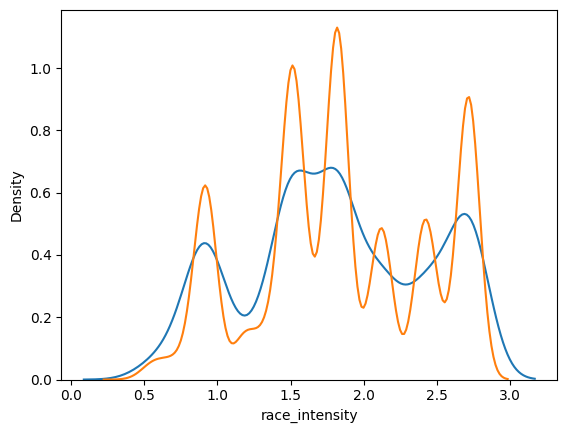

In [14]:

sns.kdeplot(full_dataset.iloc[highly_impacted_instances_dt], x="race_intensity")
sns.kdeplot(full_dataset.iloc[moderately_impacted_instances_dt], x="race_intensity")

<Axes: xlabel='climb_total', ylabel='Density'>

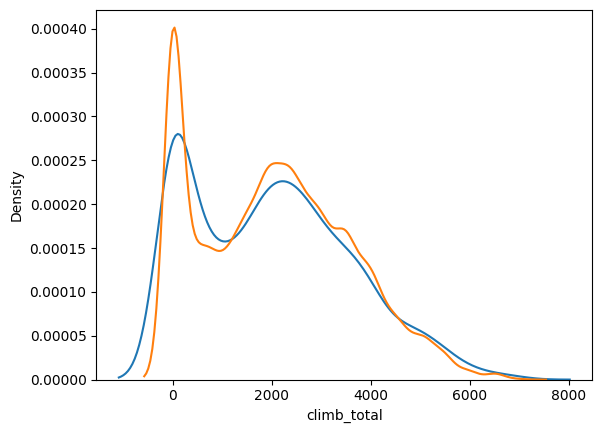

In [15]:
sns.kdeplot(full_dataset.iloc[highly_impacted_instances_dt], x="climb_total")
sns.kdeplot(full_dataset.iloc[moderately_impacted_instances_dt], x="climb_total")

Validation with classification report:

Precision: Measures prediction correctness.
    Not Top 20 (0.95) is high, indicating few false positives.
    Top 20 (0.33) is low, showing many false positives due to class imbalance.

Recall: Measures how well the model identifies actual instances.
    Not Top 20 (0.75) captures most instances.
    Top 20 (0.77) is higher than precision, indicating the model identifies most Top 20 instances but overpredicts them, causing false positives.

The **F1-score** combines precision and recall into a single metric using their harmonic mean, balancing their trade-off. For the "Not Top 20" class, the F1-score is 0.838, reflecting a strong balance between high precision (95%) and reasonable recall (75%). In contrast, the "Top 20" class has a lower F1-score of 0.464 due to poor precision (33%) despite relatively high recall (77%). The overall F1-score of 0.751 represents a weighted average across both classes, indicating moderate overall performance.

The **support** metric refers to the number of actual instances in each class. The "Not Top 20" class has 30,466 instances, dominating the dataset, while the "Top 20" class is a minority with only 4,940 instances. The total support is 35,406, which represents the full dataset. This class imbalance significantly impacts the performance metrics, as the model performs better on the majority class but struggles with the minority class.


In [16]:
validation_dt = classification_report(test_target, dt.predict(test_feature), target_names=['Not Top 20', 'Top 20'],output_dict=True)
pd.DataFrame(validation_dt)

,Not Top 20,Top 20,accuracy,macro avg,weighted avg
precision,0.952687,0.331707,0.751342,0.642197,0.866046
recall,0.748178,0.770850,0.751342,0.759514,0.751342
f1-score,0.838138,0.463825,0.751342,0.650981,0.785912
support,30466.000000,4940.000000,0.751342,35406.000000,35406.000000


In [17]:
mean_absolute_importances_dt = interventional_explanations_df_dt.abs().mean()
features_by_importance_dt = interventional_explanations_df_dt.columns[mean_absolute_importances_dt.argsort()].tolist()
features_by_importance_dt

['is_tarmac',
 'nationality',
 'cyclist_url',
 'season',
 'month',
 'cyclist_age',
 'continent',
 'profile',
 'length',
 'points',
 'race_url',
 'startlist_quality',
 'bmi',
 'date',
 'race_intensity',
 'climb_total',
 'delta']

assess the robustness of a trained classification model (dt) against noise introduced to its input features. Specifically, it investigates how adding random noise to each feature, scaled by different magnitudes, affects the model's performance measured by the F1-score. we can use other metrics like precision...

In [18]:
random_noise = np.random.rand(test_feature.shape[0],)
noise_magnitudes = [eps / 10 for eps in range(1, 10)]

corruptions_by_feature_and_noise_dt = dict()
for feature in features_by_importance_dt:
    for noise_magnitude in noise_magnitudes:
        corruptions_by_feature_and_noise_dt[(feature, noise_magnitude)] = test_feature.copy()
        corruptions_by_feature_and_noise_dt[(feature, noise_magnitude)][feature] = corruptions_by_feature_and_noise_dt[(feature, noise_magnitude)][feature] + random_noise * noise_magnitude


validations_by_feature_and_noise_dt = dict()
for (feature, noise), corruption in corruptions_by_feature_and_noise_dt.items():
    validations_by_feature_and_noise_dt[(feature, noise)] = classification_report(test_target, dt.predict(corruption), target_names=['Not Top 20', 'Top 20'], output_dict=True)


metric = "f1-score"
corruption_validation_dt = pd.DataFrame([
    (feature, noise_magnitude, validations_by_feature_and_noise_dt[(feature, noise_magnitude)]["weighted avg"][metric], "shap")
    for feature, noise_magnitude in validations_by_feature_and_noise_dt
    ],
    columns=["feature", "noise_magnitude", "performance", "algorithm"]
)
corruption_validation_dt["difference"] = corruption_validation_dt["performance"] - validation_dt["weighted avg"][metric]
corruption_validation_dt

,feature,noise_magnitude,performance,algorithm,difference
0,is_tarmac,0.1,0.785912,shap,0.000000
1,is_tarmac,0.2,0.785912,shap,0.000000
2,is_tarmac,0.3,0.785912,shap,0.000000
3,is_tarmac,0.4,0.785912,shap,0.000000
4,is_tarmac,0.5,0.785912,shap,0.000000
...,...,...,...,...,...
148,delta,0.5,0.785912,shap,0.000000
149,delta,0.6,0.785971,shap,0.000059
150,delta,0.7,0.785967,shap,0.000055
151,delta,0.8,0.785910,shap,-0.000002


 Groups the 'corruption_validation_dt' DataFrame by the 'feature' column and computes descriptive statistics for the 'performance' and 'difference' columns. adding noise didnt have impact almost at all

In [19]:
corruption_validation_dt.groupby("feature").describe()[["performance", "difference"]]

performance                                          \
                        count      mean       std       min       25%   
feature                                                                 
bmi                       9.0  0.785912  0.000000  0.785912  0.785912   
climb_total               9.0  0.785912  0.000000  0.785912  0.785912   
continent                 9.0  0.785912  0.000000  0.785912  0.785912   
cyclist_age               9.0  0.785912  0.000000  0.785912  0.785912   
cyclist_url               9.0  0.785912  0.000000  0.785912  0.785912   
date                      9.0  0.785912  0.000000  0.785912  0.785912   
delta                     9.0  0.785926  0.000025  0.785910  0.785912   
is_tarmac                 9.0  0.785912  0.000000  0.785912  0.785912   
length                    9.0  0.785912  0.000000  0.785912  0.785912   
month                     9.0  0.785912  0.000000  0.785912  0.785912   
nationality               9.0  0.785912  0.000000  0.785912  0.785912   
points                    9.0  0.785912  0.000000  0.785912  0.785912   
profile                   9.0  0.785912  0.000000  0.785912  0.785912   
race_intensity            9.0  0.777116  0.009772  0.760942  0.770001   
race_url                  9.0  0.785912  0.000000  0.785912  0.785912   
season                    9.0  0.785912  0.000000  0.785912  0.785912   
startlist_quality         9.0  0.785912  0.000000  0.785912  0.785912   

                                                difference            \
                        50%       75%       max      count      mean   
feature                                                                
bmi                0.785912  0.785912  0.785912        9.0  0.000000   
climb_total        0.785912  0.785912  0.785912        9.0  0.000000   
continent          0.785912  0.785912  0.785912        9.0  0.000000   
cyclist_age        0.785912  0.785912  0.785912        9.0  0.000000   
cyclist_url        0.785912  0.785912  0.785912        9.0  0.000000   
date               0.785912  0.785912  0.785912        9.0  0.000000   
delta              0.785912  0.785929  0.785971        9.0  0.000014   
is_tarmac          0.785912  0.785912  0.785912        9.0  0.000000   
length             0.785912  0.785912  0.785912        9.0  0.000000   
month              0.785912  0.785912  0.785912        9.0  0.000000   
nationality        0.785912  0.785912  0.785912        9.0  0.000000   
points             0.785912  0.785912  0.785912        9.0  0.000000   
profile            0.785912  0.785912  0.785912        9.0  0.000000   
race_intensity     0.779587  0.785794  0.787636        9.0 -0.008796   
race_url           0.785912  0.785912  0.785912        9.0  0.000000   
season             0.785912  0.785912  0.785912        9.0  0.000000   
startlist_quality  0.785912  0.785912  0.785912        9.0  0.000000   

                                                                               
                        std       min       25%       50%       75%       max  
feature                                                                        
bmi                0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
climb_total        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
continent          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
cyclist_age        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
cyclist_url        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
date               0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
delta              0.000025 -0.000002  0.000000  0.000000  0.000017  0.000059  
is_tarmac          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
length             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
month              0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
nationality        0.000000  0.000000  0.000000  0.000000  0.000000  0.00000

The table shows how performance and difference vary with increasing noise magnitude.
At higher noise levels (0.7 to 0.9), the model's mean performance drops slightly from 0.786012 to 0.784421 (about 0.16%), but variability increases significantly, with the standard deviation rising from 0.000412 to 0.006214. This indicates greater instability in predictions, despite a minimal average performance decline.

In [20]:
corruption_validation_dt.groupby("noise_magnitude").describe()[["performance", "difference"]]

performance                                                    \
                      count      mean       std       min       25%       50%   
noise_magnitude                                                                 
0.1                    17.0  0.786014  0.000418  0.785912  0.785912  0.785912   
0.2                    17.0  0.785947  0.000143  0.785912  0.785912  0.785912   
0.3                    17.0  0.785905  0.000029  0.785794  0.785912  0.785912   
0.4                    17.0  0.785682  0.000950  0.781993  0.785912  0.785912   
0.5                    17.0  0.785540  0.001534  0.779587  0.785912  0.785912   
0.6                    17.0  0.785369  0.002256  0.776614  0.785912  0.785912   
0.7                    17.0  0.784979  0.003860  0.770001  0.785912  0.785912   
0.8                    17.0  0.784680  0.005078  0.764973  0.785912  0.785912   
0.9                    17.0  0.784444  0.006056  0.760942  0.785912  0.785912   

                                    difference                                \
                      75%       max      count      mean       std       min   
noise_magnitude                                                                
0.1              0.785912  0.787636       17.0  0.000101  0.000418  0.000000   
0.2              0.785912  0.786501       17.0  0.000035  0.000143  0.000000   
0.3              0.785912  0.785912       17.0 -0.000007  0.000029 -0.000118   
0.4              0.785912  0.785912       17.0 -0.000231  0.000950 -0.003919   
0.5              0.785912  0.785912       17.0 -0.000372  0.001534 -0.006325   
0.6              0.785912  0.785971       17.0 -0.000543  0.002256 -0.009298   
0.7              0.785912  0.785967       17.0 -0.000933  0.003860 -0.015911   
0.8              0.785912  0.785912       17.0 -0.001232  0.005078 -0.020939   
0.9              0.785912  0.785929       17.0 -0.001468  0.006056 -0.024970   

                                          
                 25%  50%  75%       max  
noise_magnitude                           
0.1              0.0  0.0  0.0  0.001724  
0.2              0.0  0.0  0.0  0.000589  
0.3              0.0  0.0  0.0  0.000000  
0.4              0.0  0.0  0.0  0.000000  
0.5              0.0  0.0  0.0  0.000000  
0.6              0.0  0.0  0.0  0.000059  
0.7              0.0  0.0  0.0  0.000055  
0.8              0.0  0.0  0.0  0.000000  
0.9              0.0  0.0  0.0  0.000017

#### Rule explanation

The algorithm explains the first 100 training samples by analyzing how perturbations in input features influence the model's predictions.

In [21]:
set_visualize_provider(InlineProvider())

explanation_algorithm_dt = LimeTabular(dt, train_feature)
lime_explanations_dt = np.array([np.array(e["scores"])
                                    for e in tqdm(explanation_algorithm_dt.explain_local(train_feature[:100], train_target[:100])._internal_obj["specific"])])

100%|██████████| 100/100 [00:00<00:00, 297047.03it/s]


In [22]:
metric = "f1-score"
corruption_validation_lime_dt = pd.DataFrame([
    (feature, noise_magnitude, validations_by_feature_and_noise_dt[(feature, noise_magnitude)]["weighted avg"][metric], "lime")
    for feature, noise_magnitude in validations_by_feature_and_noise_dt
    ],
    columns=["feature", "noise_magnitude", "performance", "algorithm"]
)
corruption_validation_lime_dt["difference"] = corruption_validation_lime_dt["performance"] - validation_dt["weighted avg"][metric]

corruption_validation_dt = pd.concat((corruption_validation_dt, corruption_validation_lime_dt))
corruption_validation_lime_dt

,feature,noise_magnitude,performance,algorithm,difference
0,is_tarmac,0.1,0.785912,lime,0.000000
1,is_tarmac,0.2,0.785912,lime,0.000000
2,is_tarmac,0.3,0.785912,lime,0.000000
3,is_tarmac,0.4,0.785912,lime,0.000000
4,is_tarmac,0.5,0.785912,lime,0.000000
...,...,...,...,...,...
148,delta,0.5,0.785912,lime,0.000000
149,delta,0.6,0.785971,lime,0.000059
150,delta,0.7,0.785967,lime,0.000055
151,delta,0.8,0.785910,lime,-0.000002


  For lower noise magnitudes (0.1 to 0.5), the model's performance remains stable, with no changes in the f1-score difference, indicating robustness to small perturbations. As noise magnitude increases (0.6 to 0.9), a slight improvement in performance (performance values) is observed, albeit marginal (difference values are small and positive). This suggests that for the "delta" feature, higher noise levels slightly enhance the model's predictions. 

In [23]:
corruption_validation_dt

,feature,noise_magnitude,performance,algorithm,difference
0,is_tarmac,0.1,0.785912,shap,0.000000
1,is_tarmac,0.2,0.785912,shap,0.000000
2,is_tarmac,0.3,0.785912,shap,0.000000
3,is_tarmac,0.4,0.785912,shap,0.000000
4,is_tarmac,0.5,0.785912,shap,0.000000
...,...,...,...,...,...
148,delta,0.5,0.785912,lime,0.000000
149,delta,0.6,0.785971,lime,0.000059
150,delta,0.7,0.785967,lime,0.000055
151,delta,0.8,0.785910,lime,-0.000002


#### Lore

Initialize and configure the LORE explanation algorithm.
Create a random neighborhood around the data point using the specified configuration parameters.
Fit the LORE explainer using the training dataset, with the target column identified as "top_20".
Generate an explanation for the first data point in the training set.

In [ ]:
explanation_algorithm_dt = LoreTabularExplainer(dt)
configuration = {
    "neigh_type": "rndgen",
    "size": 1000,
    "ocr": 0.1,
    "ngen": 100
}

lore_train = pd.concat((train_feature, train_target), axis="columns")
explanation_algorithm_dt.fit(lore_train, "top_20", config=configuration)
explanation_dt = explanation_algorithm_dt.explain(train_feature.iloc[0].values)

explanation_dt.getRules()

Retrieve the counterfactual rules generated by the LORE explanation.
These rules highlight the minimal changes required in feature values to alter the model's prediction for the given instance.


In [25]:
explanation_dt.getCounterfactualRules()

[{'premise': [{'att': 'delta', 'op': '>', 'thr': 27.5, 'is_continuous': True},
   {'att': 'climb_total', 'op': '<=', 'thr': 3032.5, 'is_continuous': True},
   {'att': 'race_intensity',
    'op': '<=',
    'thr': 2.418582558631897,
    'is_continuous': True},
   {'att': 'race_intensity',
    'op': '>',
    'thr': 0.95161372423172,
    'is_continuous': True},
   {'att': 'startlist_quality',
    'op': '>',
    'thr': 900.5,
    'is_continuous': True},
   {'att': 'length', 'op': '>', 'thr': 15000.0, 'is_continuous': True}],
  'cons': 0,
  'class_name': 'top_20'}]

In [26]:
explanation_dt.plotRules()

In [27]:
# Generate model rules
print("Model Rules:")
print(export_text(dt, feature_names=list(test_feature.columns)))

Model Rules:
|--- delta <= 261.50
|   |--- climb_total <= 3049.50
|   |   |--- race_intensity <= 0.96
|   |   |   |--- date <= 1995.50
|   |   |   |   |--- race_url <= 4240.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- race_url >  4240.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- date >  1995.50
|   |   |   |   |--- delta <= 131.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- delta >  131.50
|   |   |   |   |   |--- class: 0
|   |   |--- race_intensity >  0.96
|   |   |   |--- delta <= 27.50
|   |   |   |   |--- bmi <= 21.53
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- bmi >  21.53
|   |   |   |   |   |--- class: 1
|   |   |   |--- delta >  27.50
|   |   |   |   |--- race_intensity <= 2.42
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- race_intensity >  2.42
|   |   |   |   |   |--- class: 1
|   |--- climb_total >  3049.50
|   |   |--- race_intensity <= 2.26
|   |   |   |--- delta <= 67.50
|   |   |   |   |--- race_intensity <= 0.96
|   

#### Counterfactual instances

In [ ]:
# need to convert data to the Dice format
dice_train_dataset = train_feature.copy()
dice_train_dataset["top_20"] = train_target
dice_dataset = dice_ml.Data(
    dataframe=dice_train_dataset,
    outcome_name="top_20",
    continuous_features=dice_train_dataset.columns.tolist()[:-1]
)

dice_model_dt = dice_ml.Model(
    model=dt,
    backend="sklearn",  # dice supports several frameworks, e.g., pytorch, tensorflow
)

# the Dice object interfaces the counterfactual search
explanation_algorithm_dt = dice_ml.Dice(
    dice_dataset,
    dice_model_dt,
    method="random"  # random search for counterfactuals
    # method="gradient"  # gradient ASCent
    # method="genetic"  # genetic algorithm for search
)

explanation_dt = explanation_algorithm_dt.generate_counterfactuals(
    dice_train_dataset.head(1).drop("top_20", axis="columns"),
    total_CFs=10,  # number of counterfactuals to generate
)

100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


In [29]:
explanation_dt.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 1)


,race_url,points,length,climb_total,profile,startlist_quality,date,cyclist_age,is_tarmac,delta,month,season,race_intensity,cyclist_url,nationality,bmi,continent,top_20
0,2408,100.0,162000.0,1101.0,1.0,1241.0,1978,22.0,1,0.0,7.0,2,1.503613,5310,32,23.765432,3,1



Diverse Counterfactual set (new outcome: 0)


,race_url,points,length,climb_total,profile,startlist_quality,date,cyclist_age,is_tarmac,delta,month,season,race_intensity,cyclist_url,nationality,bmi,continent,top_20
0,-,-,-,-,-,-,-,-,-,15902.9,-,-,-,-,-,-,-,0.0
1,-,-,-,-,-,-,-,-,-,33134.1,-,-,-,-,-,-,-,0.0
2,-,-,-,-,-,-,-,-,-,13526.1,-,-,-,-,-,-,-,0.0
3,-,-,-,-,-,-,-,-,-,2194.2,-,-,-,-,-,-,-,0.0
4,-,-,-,-,2.2,-,-,-,-,47007.7,-,-,-,-,-,-,-,0.0
5,-,-,-,-,-,-,-,-,-,382.3,-,-,-,-,-,-,-,0.0
6,-,-,-,-,-,-,-,54.3,-,11676.4,-,-,-,-,-,-,-,0.0
7,-,-,-,-,-,-,-,34.0,-,29388.3,-,-,-,-,-,-,-,0.0
8,-,-,-,-,-,-,-,-,-,2194.2,-,-,-,-,44.0,-,-,0.0
9,-,-,-,-,2.8,-,-,-,-,58657.6,-,-,-,-,-,-,-,0.0


### Random Forest

In [30]:
# Import the model
rf = load('./models/random_forest.joblib')

#### Feature importance

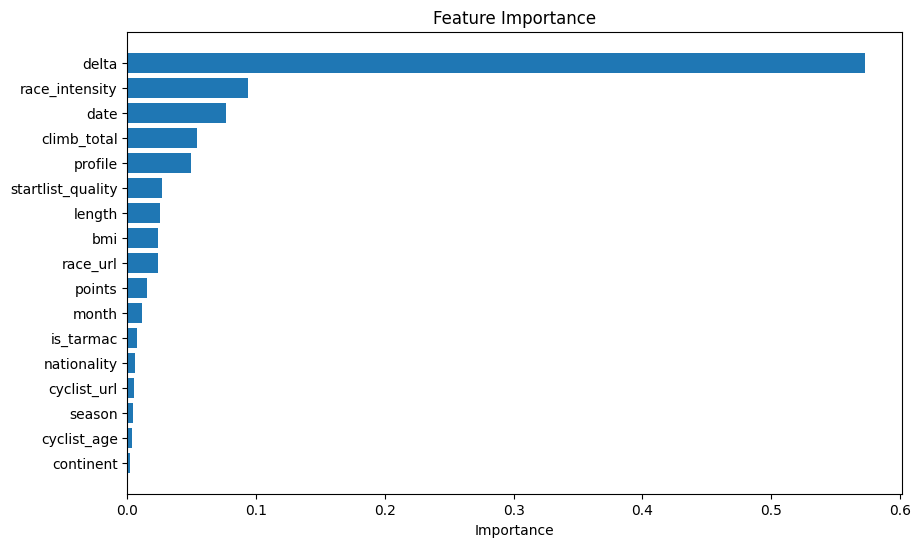

In [ ]:
# Plot feature importance
plot_feature_importance(rf, test_feature.columns)

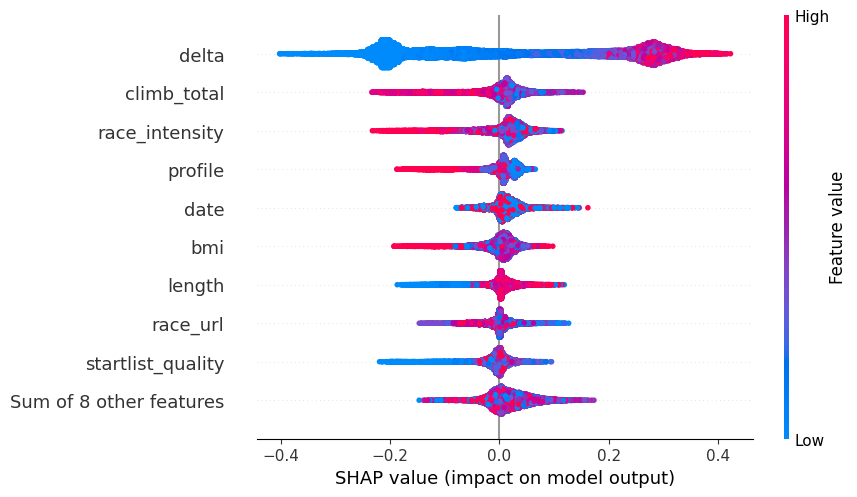

In [ ]:
interventional_explanation_algorithm_rf = shap.TreeExplainer(
    model=rf,
    data=train_feature,         # perturb on a causal model induced on perturbation data
    feature_perturbation="interventional",  # use a causal model
    approximate=True # use of approximation to speed up the computation
)

distributional_explanation_algorithm_rf = shap.TreeExplainer(
    model=rf,
    feature_perturbation="tree_path_dependent", # condition on the distribution learned on the train data
    approximate=True # use of approximation to speed up the computation
)

interventional_explanations_rf = interventional_explanation_algorithm_rf(test_feature)
distributional_explanations_rf = distributional_explanation_algorithm_rf(test_feature)

shap.plots.beeswarm(interventional_explanations_rf[:, :, 0])

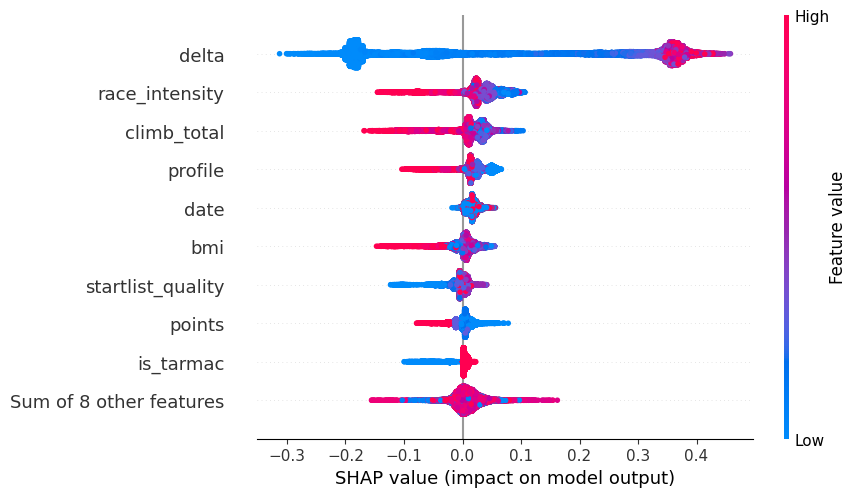

In [ ]:
shap.plots.beeswarm(distributional_explanations_rf[:, :, 0])

<Axes: ylabel='Density'>

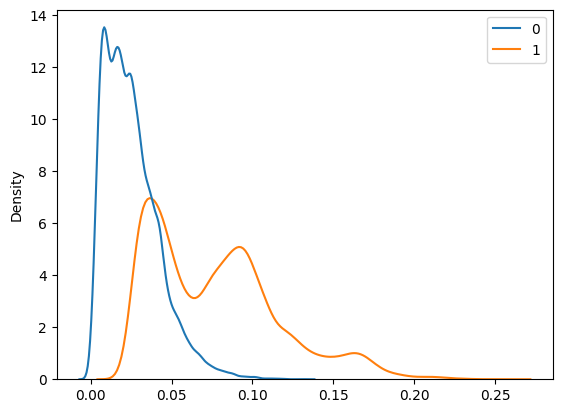

In [ ]:
explanation_differences_rf = interventional_explanations_rf.values - distributional_explanations_rf.values

maximum_differences_per_instance_rf = explanation_differences_rf.max(axis=1)
sns.kdeplot(maximum_differences_per_instance_rf)

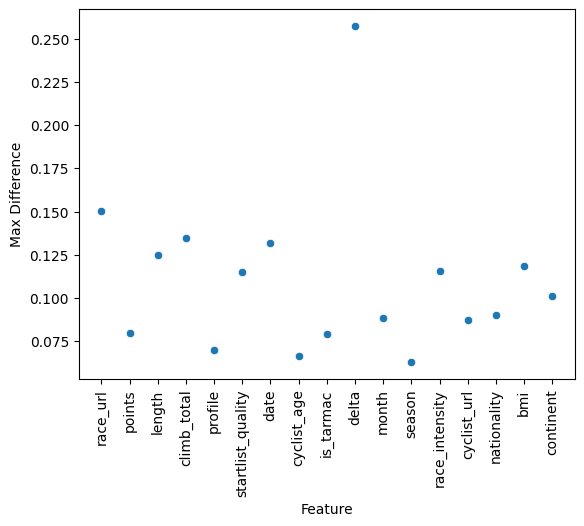

In [ ]:
maximum_differences_per_feature_rf = explanation_differences_rf.max(axis=0)

feature_importances_rf = pd.DataFrame({
    'Feature': columns,
    'Max Difference': maximum_differences_per_feature_rf.max(axis=1)
})

sns.scatterplot(x='Feature', y='Max Difference', data=feature_importances_rf)
plt.xticks(rotation=90)
plt.show()

In [ ]:
interventional_explanations_df_rf = pd.DataFrame(interventional_explanations_rf[:, :, 0].values, columns=columns)
interventional_explanations_df_rf.describe().drop("count", axis="rows")

,race_url,points,length,climb_total,profile,startlist_quality,date,cyclist_age,is_tarmac,delta,month,season,race_intensity,cyclist_url,nationality,bmi,continent
mean,-0.001724,-0.001310,-0.000542,-0.003884,0.005730,-0.005644,0.012737,0.004270,-0.001683,0.033493,0.002164,0.000360,0.009318,0.007045,0.003954,0.000938,0.003709
std,0.024845,0.013008,0.032246,0.052632,0.032580,0.026812,0.022991,0.010641,0.006915,0.206243,0.012602,0.008768,0.041872,0.014115,0.010862,0.028897,0.008523
min,-0.146819,-0.077783,-0.187196,-0.233473,-0.187848,-0.219588,-0.079240,-0.048832,-0.083064,-0.402526,-0.108575,-0.042571,-0.232688,-0.093510,-0.069143,-0.193186,-0.060179
25%,-0.009877,-0.006567,-0.003500,-0.010311,0.000921,-0.012164,0.001892,-0.001746,-0.001586,-0.177843,-0.004528,-0.001693,0.000344,0.000833,-0.002061,-0.008164,-0.000171
50%,0.000448,-0.000583,0.003432,0.009568,0.010377,-0.002043,0.012004,0.001919,-0.001151,-0.006556,0.001477,0.000639,0.018906,0.005110,0.001758,0.006189,0.000067
75%,0.009896,0.004443,0.013786,0.022090,0.024993,0.006201,0.024910,0.009387,-0.000769,0.256446,0.008763,0.002386,0.032826,0.013593,0.009778,0.016932,0.008993
max,0.126681,0.055962,0.118702,0.153074,0.065693,0.095335,0.161816,0.071062,0.042716,0.422746,0.066309,0.039611,0.114576,0.092471,0.062769,0.097566,0.050000


<Axes: xlabel='race_intensity', ylabel='Density'>

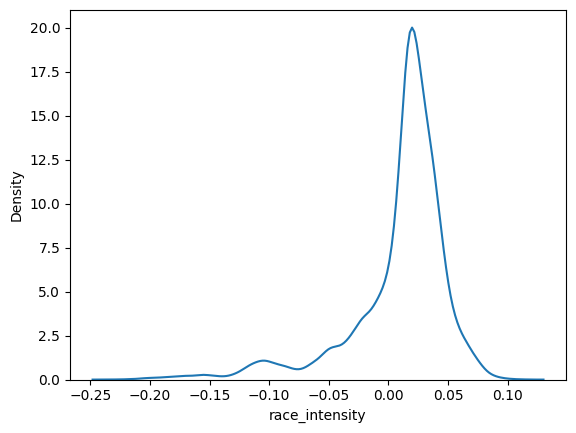

In [ ]:
feature_of_interest = "race_intensity"
sns.kdeplot(interventional_explanations_df_rf, x=feature_of_interest)

In [38]:
number_quantiles = 40
quantiles_rf = interventional_explanations_df_dt["delta"].quantile([q / number_quantiles for q in (range(number_quantiles))])

print("Differences between quantiles:\n", quantiles_rf.diff())

Differences between quantiles:
 0.000         NaN
0.025    0.011724
0.050    0.002564
0.075    0.011273
0.100    0.037614
0.125    0.000617
0.150    0.001947
0.175    0.000143
0.200    0.000474
0.225    0.000143
0.250    0.001558
0.275    0.028499
0.300    0.027397
0.325    0.081181
0.350    0.002266
0.375    0.005607
0.400    0.004265
0.425    0.014646
0.450    0.006583
0.475    0.005850
0.500    0.010488
0.525    0.018987
0.550    0.235260
0.575    0.012845
0.600    0.006260
0.625    0.018577
0.650    0.028592
0.675    0.021817
0.700    0.031005
0.725    0.018745
0.750    0.008039
0.775    0.030845
0.800    0.035314
0.825    0.020788
0.850    0.024892
0.875    0.023934
0.900    0.013084
0.925    0.007428
0.950    0.009750
0.975    0.008821
Name: delta, dtype: float64


In [ ]:
interested_explanations_rf = interventional_explanations_df_rf[feature_of_interest].values
quantile_of_interest_rf = quantiles_rf[0.025]


highly_impacted_instances_rf = np.argwhere(interested_explanations_rf <= quantile_of_interest_rf).squeeze()
moderately_impacted_instances_rf = np.array([i for i in range(interventional_explanations_rf.shape[0]) if i not in highly_impacted_instances_rf])

full_dataset.iloc[highly_impacted_instances_rf].describe().drop("count", axis="rows") - full_dataset.iloc[moderately_impacted_instances_rf].describe().drop("count", axis="rows")

,race_url,points,length,climb_total,profile,startlist_quality,date,cyclist_age,is_tarmac,delta,month,season,race_intensity,cyclist_url,nationality,bmi,continent
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='race_intensity', ylabel='Density'>

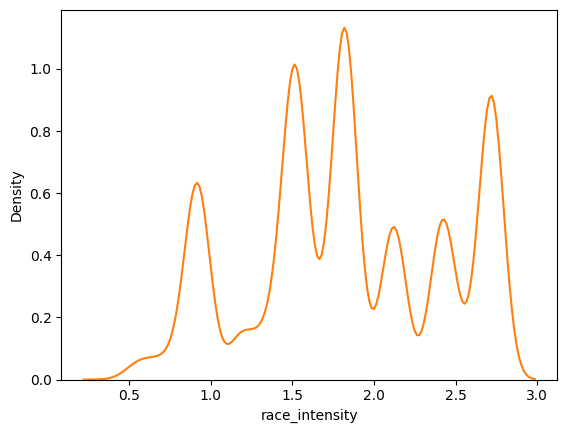

In [ ]:
sns.kdeplot(full_dataset.iloc[highly_impacted_instances_rf], x="race_intensity")
sns.kdeplot(full_dataset.iloc[moderately_impacted_instances_rf], x="race_intensity")

<Axes: xlabel='climb_total', ylabel='Density'>

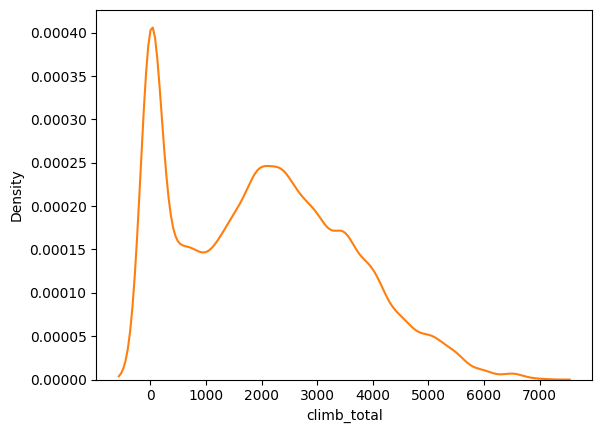

In [ ]:
sns.kdeplot(full_dataset.iloc[highly_impacted_instances_rf], x="climb_total")
sns.kdeplot(full_dataset.iloc[moderately_impacted_instances_rf], x="climb_total")

Validation with classification report:

In [ ]:
validation_rf = classification_report(test_target, rf.predict(test_feature), target_names=['Not Top 20', 'Top 20'],output_dict=True)
pd.DataFrame(validation_rf)

,Not Top 20,Top 20,accuracy,macro avg,weighted avg
precision,0.959511,0.398509,0.804327,0.679010,0.881238
recall,0.806637,0.790081,0.804327,0.798359,0.804327
f1-score,0.876458,0.529795,0.804327,0.703126,0.828090
support,30466.000000,4940.000000,0.804327,35406.000000,35406.000000


In [43]:
mean_absolute_importances_rf = interventional_explanations_df_rf.abs().mean()
features_by_importance_rf = interventional_explanations_df_rf.columns[mean_absolute_importances_rf.argsort()].tolist()
features_by_importance_rf

['is_tarmac',
 'continent',
 'season',
 'cyclist_age',
 'nationality',
 'points',
 'month',
 'cyclist_url',
 'startlist_quality',
 'race_url',
 'length',
 'bmi',
 'date',
 'profile',
 'race_intensity',
 'climb_total',
 'delta']

In [ ]:
random_noise = np.random.rand(test_feature.shape[0],)
noise_magnitudes = [eps / 10 for eps in range(1, 10)]

corruptions_by_feature_and_noise_rf = dict()
for feature in features_by_importance_rf:
    for noise_magnitude in noise_magnitudes:
        corruptions_by_feature_and_noise_rf[(feature, noise_magnitude)] = test_feature.copy()
        corruptions_by_feature_and_noise_rf[(feature, noise_magnitude)][feature] = corruptions_by_feature_and_noise_rf[(feature, noise_magnitude)][feature] + random_noise * noise_magnitude


validations_by_feature_and_noise_rf = dict()
for (feature, noise), corruption in corruptions_by_feature_and_noise_rf.items():
    validations_by_feature_and_noise_rf[(feature, noise)] = classification_report(test_target, rf.predict(corruption), target_names=['Not Top 20', 'Top 20'], output_dict=True)


metric = "f1-score"
corruption_validation_rf = pd.DataFrame([
    (feature, noise_magnitude, validations_by_feature_and_noise_rf[(feature, noise_magnitude)]["weighted avg"][metric], "shap")
    for feature, noise_magnitude in validations_by_feature_and_noise_rf
    ],
    columns=["feature", "noise_magnitude", "performance", "algorithm"]
)
corruption_validation_rf["difference"] = corruption_validation_rf["performance"] - validation_rf["weighted avg"][metric]
corruption_validation_rf

,feature,noise_magnitude,performance,algorithm,difference
0,is_tarmac,0.1,0.828090,shap,0.000000
1,is_tarmac,0.2,0.828090,shap,0.000000
2,is_tarmac,0.3,0.828090,shap,0.000000
3,is_tarmac,0.4,0.828090,shap,0.000000
4,is_tarmac,0.5,0.828090,shap,0.000000
...,...,...,...,...,...
148,delta,0.5,0.828112,shap,0.000022
149,delta,0.6,0.828040,shap,-0.000050
150,delta,0.7,0.827837,shap,-0.000253
151,delta,0.8,0.827777,shap,-0.000313


In [ ]:
corruption_validation_rf.groupby("feature").describe()[["performance", "difference"]]

performance                                          \
                        count      mean       std       min       25%   
feature                                                                 
bmi                       9.0  0.825700  0.001399  0.823370  0.824975   
climb_total               9.0  0.828102  0.000014  0.828090  0.828090   
continent                 9.0  0.828297  0.000272  0.828090  0.828090   
cyclist_age               9.0  0.828289  0.000254  0.828090  0.828090   
cyclist_url               9.0  0.828090  0.000000  0.828090  0.828090   
date                      9.0  0.828090  0.000000  0.828090  0.828090   
delta                     9.0  0.828004  0.000147  0.827777  0.827837   
is_tarmac                 9.0  0.827987  0.000140  0.827720  0.827919   
length                    9.0  0.828090  0.000000  0.828090  0.828090   
month                     9.0  0.827994  0.000130  0.827776  0.827888   
nationality               9.0  0.828127  0.000049  0.828090  0.828090   
points                    9.0  0.828090  0.000000  0.828090  0.828090   
profile                   9.0  0.825267  0.003677  0.819138  0.822414   
race_intensity            9.0  0.799785  0.011882  0.782705  0.790744   
race_url                  9.0  0.828090  0.000000  0.828090  0.828090   
season                    9.0  0.828048  0.000079  0.827912  0.828050   
startlist_quality         9.0  0.828114  0.000029  0.828090  0.828090   

                                                difference            \
                        50%       75%       max      count      mean   
feature                                                                
bmi                0.825552  0.826816  0.827639        9.0 -0.002389   
climb_total        0.828090  0.828117  0.828117        9.0  0.000012   
continent          0.828090  0.828487  0.828771        9.0  0.000207   
cyclist_age        0.828090  0.828453  0.828698        9.0  0.000199   
cyclist_url        0.828090  0.828090  0.828090        9.0  0.000000   
date               0.828090  0.828090  0.828090        9.0  0.000000   
delta              0.828112  0.828112  0.828112        9.0 -0.000086   
is_tarmac          0.828090  0.828090  0.828090        9.0 -0.000103   
length             0.828090  0.828090  0.828090        9.0  0.000000   
month              0.828090  0.828090  0.828090        9.0 -0.000096   
nationality        0.828090  0.828157  0.828201        9.0  0.000037   
points             0.828090  0.828090  0.828090        9.0  0.000000   
profile            0.828090  0.828090  0.828090        9.0 -0.002823   
race_intensity     0.799384  0.810348  0.816287        9.0 -0.028305   
race_url           0.828090  0.828090  0.828090        9.0  0.000000   
season             0.828090  0.828090  0.828107        9.0 -0.000042   
startlist_quality  0.828090  0.828145  0.828145        9.0  0.000024   

                                                                               
                        std       min       25%       50%       75%       max  
feature                                                                        
bmi                0.001399 -0.004719 -0.003115 -0.002538 -0.001274 -0.000451  
climb_total        0.000014  0.000000  0.000000  0.000000  0.000027  0.000027  
continent          0.000272  0.000000  0.000000  0.000000  0.000397  0.000681  
cyclist_age        0.000254  0.000000  0.000000  0.000000  0.000363  0.000608  
cyclist_url        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
date               0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
delta              0.000147 -0.000313 -0.000253  0.000022  0.000022  0.000022  
is_tarmac          0.000140 -0.000370 -0.000171  0.000000  0.000000  0.000000  
length             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
month              0.000130 -0.000313 -0.000202  0.000000  0.000000  0.000000  
nationality        0.000049  0.000000  0.000000  0.000000  0.000067  0.00011

In [ ]:
corruption_validation_rf.groupby("noise_magnitude").describe()[["performance", "difference"]]

performance                                                   \
                      count      mean       std       min       25%      50%   
noise_magnitude                                                                
0.1                    17.0  0.827370  0.002858  0.816287  0.828090  0.82809   
0.2                    17.0  0.827101  0.003865  0.812126  0.828090  0.82809   
0.3                    17.0  0.826973  0.004295  0.810348  0.828090  0.82809   
0.4                    17.0  0.826600  0.005660  0.804714  0.828090  0.82809   
0.5                    17.0  0.826253  0.006951  0.799384  0.828090  0.82809   
0.6                    17.0  0.825826  0.007967  0.795159  0.828011  0.82809   
0.7                    17.0  0.825390  0.009059  0.790744  0.827888  0.82809   
0.8                    17.0  0.824994  0.010098  0.786596  0.827819  0.82809   
0.9                    17.0  0.824637  0.011070  0.782705  0.827776  0.82809   

                                    difference                                \
                      75%       max      count      mean       std       min   
noise_magnitude                                                                
0.1              0.828090  0.828112       17.0 -0.000720  0.002858 -0.011803   
0.2              0.828090  0.828112       17.0 -0.000989  0.003865 -0.015964   
0.3              0.828090  0.828112       17.0 -0.001117  0.004295 -0.017742   
0.4              0.828090  0.828112       17.0 -0.001490  0.005660 -0.023376   
0.5              0.828090  0.828112       17.0 -0.001837  0.006951 -0.028706   
0.6              0.828117  0.828369       17.0 -0.002264  0.007967 -0.032931   
0.7              0.828117  0.828487       17.0 -0.002700  0.009059 -0.037346   
0.8              0.828117  0.828638       17.0 -0.003095  0.010098 -0.041494   
0.9              0.828117  0.828771       17.0 -0.003453  0.011070 -0.045385   

                                                    
                      25%  50%       75%       max  
noise_magnitude                                     
0.1              0.000000  0.0  0.000000  0.000022  
0.2              0.000000  0.0  0.000000  0.000022  
0.3              0.000000  0.0  0.000000  0.000022  
0.4              0.000000  0.0  0.000000  0.000022  
0.5              0.000000  0.0  0.000000  0.000022  
0.6             -0.000079  0.0  0.000027  0.000279  
0.7             -0.000202  0.0  0.000027  0.000397  
0.8             -0.000270  0.0  0.000027  0.000548  
0.9             -0.000313  0.0  0.000027  0.000681

#### Rule explanation

In [ ]:
set_visualize_provider(InlineProvider())

explanation_algorithm_rf = LimeTabular(rf, train_feature)
lime_explanations_rf = np.array([np.array(e["scores"])
                                    for e in tqdm(explanation_algorithm_rf.explain_local(train_feature[:100], train_target[:100])._internal_obj["specific"])])

100%|██████████| 100/100 [00:00<00:00, 330520.41it/s]


In [ ]:
metric = "f1-score"
corruption_validation_lime_rf = pd.DataFrame([
    (feature, noise_magnitude, validations_by_feature_and_noise_rf[(feature, noise_magnitude)]["weighted avg"][metric], "lime")
    for feature, noise_magnitude in validations_by_feature_and_noise_rf
    ],
    columns=["feature", "noise_magnitude", "performance", "algorithm"]
)
corruption_validation_lime_rf["difference"] = corruption_validation_lime_rf["performance"] - validation_rf["weighted avg"][metric]

corruption_validation_rf = pd.concat((corruption_validation_rf, corruption_validation_lime_rf))
corruption_validation_lime_rf

,feature,noise_magnitude,performance,algorithm,difference
0,is_tarmac,0.1,0.828090,lime,0.000000
1,is_tarmac,0.2,0.828090,lime,0.000000
2,is_tarmac,0.3,0.828090,lime,0.000000
3,is_tarmac,0.4,0.828090,lime,0.000000
4,is_tarmac,0.5,0.828090,lime,0.000000
...,...,...,...,...,...
148,delta,0.5,0.828112,lime,0.000022
149,delta,0.6,0.828040,lime,-0.000050
150,delta,0.7,0.827837,lime,-0.000253
151,delta,0.8,0.827777,lime,-0.000313


In [ ]:
corruption_validation_rf

,feature,noise_magnitude,performance,algorithm,difference
0,is_tarmac,0.1,0.828090,shap,0.000000
1,is_tarmac,0.2,0.828090,shap,0.000000
2,is_tarmac,0.3,0.828090,shap,0.000000
3,is_tarmac,0.4,0.828090,shap,0.000000
4,is_tarmac,0.5,0.828090,shap,0.000000
...,...,...,...,...,...
148,delta,0.5,0.828112,lime,0.000022
149,delta,0.6,0.828040,lime,-0.000050
150,delta,0.7,0.827837,lime,-0.000253
151,delta,0.8,0.827777,lime,-0.000313


Lore

In [50]:
## COMMENTATO PERCHE' CI METTE 10 MINUTI MA FUNZIONA

# explanation_algorithm_rf = LoreTabularExplainer(rf)
# configuration = {
#     "neigh_type": "rndgen",
#     "size": 1000,
#     "ocr": 0.1,
#     "ngen": 100
# }

# lore_train = pd.concat((train_feature, train_target), axis="columns")
# explanation_algorithm_rf.fit(lore_train, "top_20", config=configuration)
# explanation_rf = explanation_algorithm_rf.explain(train_feature.iloc[0].values)

# explanation_rf.getRules()

In [51]:
# explanation_rf.getCounterfactualRules()

In [52]:
# explanation_rf.plotRules()

##### Counterfactual instances

In [ ]:
dice_model_rf = dice_ml.Model(
    model=rf,
    backend="sklearn",  # dice supports several frameworks, e.g., pytorch, tensorflow
)

# the Dice object interfaces the counterfactual search
explanation_algorithm_rf = dice_ml.Dice(
    dice_dataset,
    dice_model_rf,
    method="random"  # random search for counterfactuals
    # method="gradient"  # gradient ASCent
    # method="genetic"  # genetic algorithm for search
)

explanation_rf = explanation_algorithm_rf.generate_counterfactuals(
    dice_train_dataset.head(1).drop("top_20", axis="columns"),
    total_CFs=10,  # number of counterfactuals to generate
)

100%|██████████| 1/1 [01:06<00:00, 66.84s/it]


In [54]:
explanation_rf.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 1)


,race_url,points,length,climb_total,profile,startlist_quality,date,cyclist_age,is_tarmac,delta,month,season,race_intensity,cyclist_url,nationality,bmi,continent,top_20
0,2408,100.0,162000.0,1101.0,1.0,1241.0,1978,22.0,1,0.0,7.0,2,1.503613,5310,32,23.765432,3,1



Diverse Counterfactual set (new outcome: 0)


,race_url,points,length,climb_total,profile,startlist_quality,date,cyclist_age,is_tarmac,delta,month,season,race_intensity,cyclist_url,nationality,bmi,continent,top_20
0,-,-,-,-,-,-,-,-,-,50374.5,-,-,-,-,-,-,-,0.0
1,4200.0,-,-,-,-,-,-,-,-,20829.2,-,-,-,-,-,-,-,0.0
2,-,-,-,-,-,-,-,-,-,39085.0,-,-,-,-,-,-,-,0.0
3,4723.0,-,-,-,-,-,-,-,-,55538.3,-,-,-,-,-,-,-,0.0
4,-,-,-,-,-,-,-,-,-,37007.7,-,-,-,-,-,-,-,0.0
5,-,-,-,-,-,-,-,-,-,34707.6,-,-,1.510089099999416,-,-,-,-,0.0
6,-,-,-,-,-,-,-,34.3,-,11435.0,-,-,-,-,-,-,-,0.0
7,-,-,-,-,-,-,-,-,-,39606.5,-,-,-,1425.0,-,-,-,0.0
8,-,-,-,5565.9,-,-,-,-,-,23933.6,-,-,-,-,-,-,-,0.0
9,-,-,-,-,-,-,-,-,-,23015.4,-,-,-,-,-,-,-,0.0


### Neural Network

In [ ]:
# Import the model
NN_model = load_model('./models/neural_network.keras')

NameError: name 'load_model' is not defined

#### Feature importance